In [1]:
pip install transformers torch numpy gudhi -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
text = ["In the early hours of the morning, after a hearty breakfast, the explorers set out on their journey. They made their way through thick and thin, forging a path through the dense forest under the clear blue sky. They hoped to catch sight of the elusive wildlife known to inhabit the area. Along the way, they encountered a steep hill. With a burst of energy, they climbed to the top and took in the breathtaking view. The landscape stretched out as far as the eye could see, from the rolling green hills to the deep blue sea. They took a few moments to savor the peace and tranquility before moving on. As the day drew to a close, they set up camp under the twinkling stars. They had a bite to eat, shared stories around the campfire, and then retired for the night, eager to see what adventures the next day would bring."]

In [3]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel


def compute_output(sentence, layer, head):
    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 182, 64])
tensor([[[ 0.0319,  0.0711, -0.0198,  ...,  0.0357, -0.0166,  0.0768],
         [ 0.0330,  0.0875, -0.0542,  ...,  0.0397,  0.0220,  0.1332],
         [-0.3975,  0.4078, -0.4424,  ...,  0.0437,  0.6609,  0.5670],
         ...,
         [-0.2061,  0.1340, -0.1667,  ...,  0.0459, -0.1356,  0.6173],
         [ 0.0326, -0.0361, -0.0229,  ..., -0.0075, -0.0634,  0.2655],
         [ 0.0334,  0.0490, -0.0256,  ...,  0.0453, -0.0173,  0.0581]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:


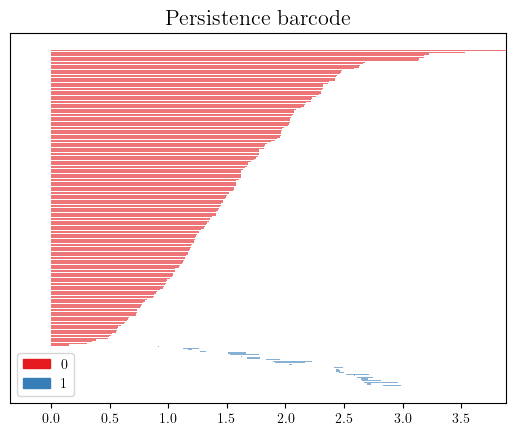

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [5]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=1.0):
    # Load pre-trained model tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: [CLS], in, ., for, dense, forest, clear, blue, sky, ., known, ., along, with, breath, the, ., as, twin, ##kling, stars, ,, ., [SEP]
Cluster 1: explorers, set
Cluster 2: to, catch
Cluster 3: the, area
Cluster 4: the, way
Cluster 5: encountered, climbed
Cluster 6: steep, hill
Cluster 7: ##taking, view
Cluster 8: as, far
Cluster 9: could, see
Cluster 10: rolling, green
Cluster 11: hills, deep, blue, sea
Cluster 12: sa, ##vor
Cluster 13: tran, ##quil
Cluster 14: moving, on
Cluster 15: camp, ##fire
Cluster 16: the, night


Tokens of the sub-collection: ['deep', 'blue', 'sea']
Distance matrix: (3, 3)
Distance matrix: [[0.         2.80995572 2.66324424]
 [2.80995572 0.         0.78284697]
 [2.66324424 0.78284697 0.        ]]


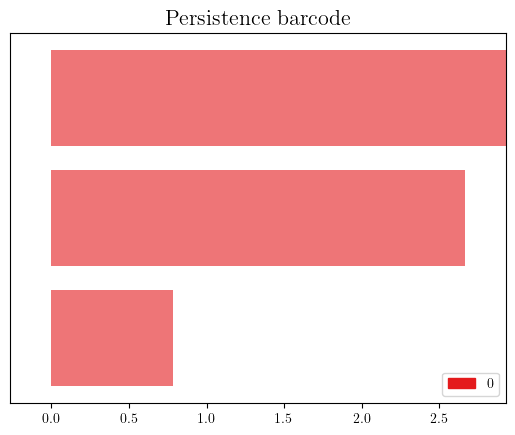

[(0, (0.0, inf)),
 (0, (0.0, 2.663244244980135)),
 (0, (0.0, 0.7828469749582948))]

In [6]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "deep blue sea")

In [11]:
text_2 = ["Late in the afternoon, a group of friends decided to embark on a fishing trip. They had been through thick and thin together and shared a common love for the great outdoors. After packing their gear and provisions, they hopped into their old but reliable boat and set off towards the deep blue sea. The day was perfect for fishing, with a cloudless sky and a gentle breeze. They spent hours casting their lines, chatting, and enjoying the serenity of the open water. As the sun began to set, they found a quiet spot to anchor for the night. Beneath the stunning canvas of stars, they prepared a simple meal, swapping tales and laughing at old memories. The quiet lapping of the waves against the boat lulled and the clear blue sky them into a peaceful sleep, their dreams filled with the anticipation of the following day's catch."]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokens of the sub-collection: ['deep', 'blue', 'sea']
Distance matrix: (3, 3)
Distance matrix: [[0.         2.07364001 2.37382141]
 [2.07364001 0.         0.50074668]
 [2.37382141 0.50074668 0.        ]]


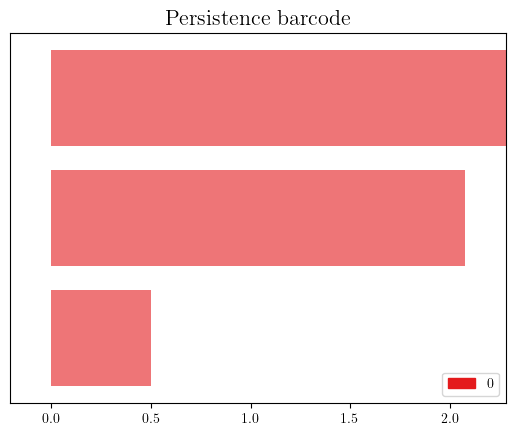

[(0, (0.0, inf)),
 (0, (0.0, 2.073640007625028)),
 (0, (0.0, 0.5007466771620743))]

In [12]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "deep blue sea")

Tokens of the sub-collection: ['deep', 'blue', 'sea']
Distance matrix: (3, 3)
Distance matrix: [[0.         2.80995572 2.66324424]
 [2.80995572 0.         0.78284697]
 [2.66324424 0.78284697 0.        ]]


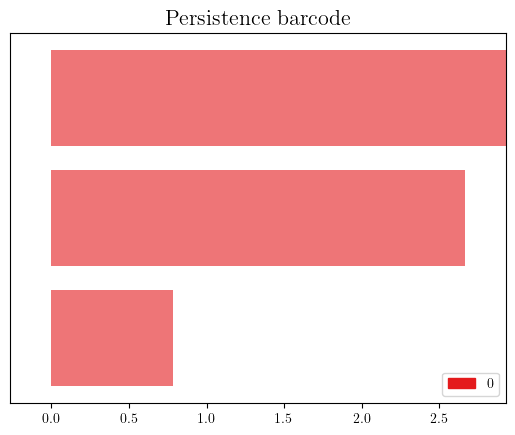

Tokens of the sub-collection: ['deep', 'blue', 'sea']
Distance matrix: (3, 3)
Distance matrix: [[0.         2.07364001 2.37382141]
 [2.07364001 0.         0.50074668]
 [2.37382141 0.50074668 0.        ]]


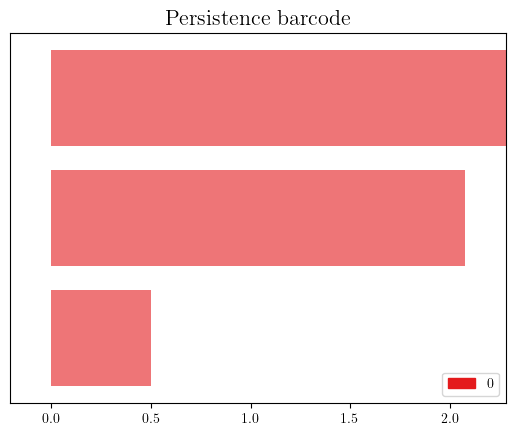

Bottleneck distance: 0.589604237355107
Wasserstein distance: = 0.87


In [13]:
# from gudhi.wasserstein import wasserstein_distance 
# Could also be: 
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "deep blue sea")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "deep blue sea")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

Tokens of the sub-collection: ['clear', 'blue', 'sky']
Distance matrix: (3, 3)
Distance matrix: [[0.         2.95604606 2.72868339]
 [2.95604606 0.         0.66655457]
 [2.72868339 0.66655457 0.        ]]


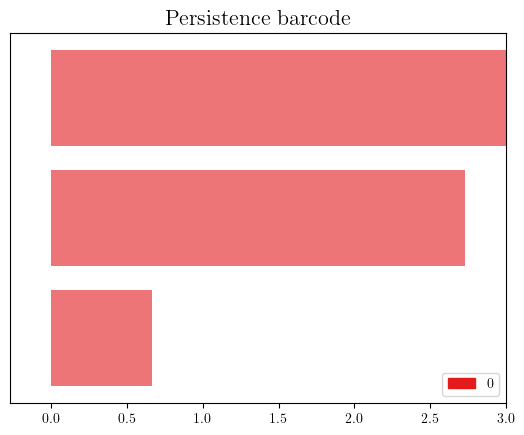

Tokens of the sub-collection: ['clear', 'blue', 'sky']
Distance matrix: (3, 3)
Distance matrix: [[0.         3.2976749  2.98793861]
 [3.2976749  0.         1.04438061]
 [2.98793861 1.04438061 0.        ]]


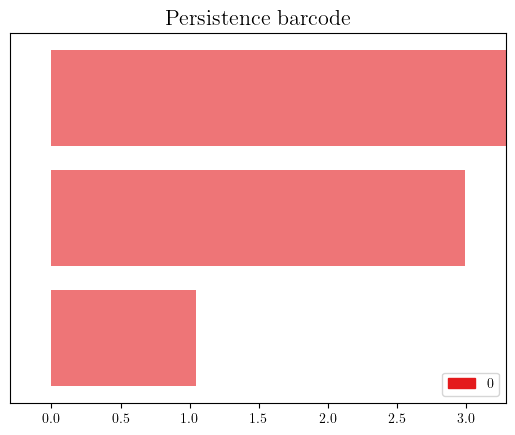

Bottleneck distance: 0.37782604432778044
Wasserstein distance: = 0.64


In [14]:
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "clear blue sky")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "clear blue sky")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Hight Overlap in Number of Collocations and Multiword Expressions

In [15]:
text_3 = ["The basketball team from our local high school was at the top of their game. They had a habit of pulling rabbits out of hats during every match, turning the tide at the last minute. Their coach, an old hand at the game, had a keen eye for detail and an ability to whip the team into shape. He was a firm believer in the saying, there's no 'I' in 'team'. The star player, an all-rounder, had the knack for scoring points in the nick of time. The spectators, holding their breath in anticipation, would often break into applause at the sight of the home team's stellar performance."]

text_4 = ["The software development team at our company was at the top of their game. They had a habit of pulling rabbits out of hats during every project, turning the tide at the last minute. Their manager, an old hand at programming, had a keen eye for detail and an ability to whip the team into shape. He was a firm believer in the saying, there's no 'I' in 'team'. The lead developer, an all-rounder, had the knack for solving problems in the nick of time. The clients, holding their breath in anticipation, would often break into applause at the sight of the team's stellar performance."]

In [16]:
context_3 = [compute_output(t, layer, head) for t in text_3]

context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relations

Tokens of the sub-collection: ['at', 'the', 'top', 'of', 'their', 'game']
Distance matrix: (6, 6)
Distance matrix: [[0.         3.4473255  3.29335968 2.39604189 2.33459259 3.05519565]
 [3.4473255  0.         0.81332376 2.11820576 3.31176134 4.14891042]
 [3.29335968 0.81332376 0.         1.49416847 2.80292721 3.66360395]
 [2.39604189 2.11820576 1.49416847 0.         1.58472179 2.68499185]
 [2.33459259 3.31176134 2.80292721 1.58472179 0.         1.38862598]
 [3.05519565 4.14891042 3.66360395 2.68499185 1.38862598 0.        ]]


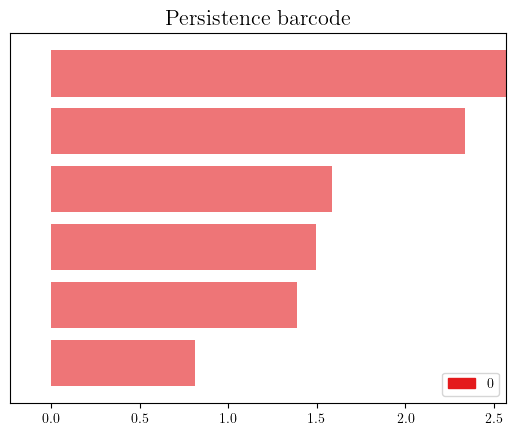

Tokens of the sub-collection: ['at', 'the', 'top', 'of', 'their', 'game']
Distance matrix: (6, 6)
Distance matrix: [[0.         3.13708197 3.22901514 2.27634498 2.28619939 2.89169475]
 [3.13708197 0.         0.79823402 1.55415889 3.0783842  3.76204959]
 [3.22901514 0.79823402 0.         1.2724851  2.80263727 3.51858608]
 [2.27634498 1.55415889 1.2724851  0.         1.76291668 2.68818728]
 [2.28619939 3.0783842  2.80263727 1.76291668 0.         1.20567506]
 [2.89169475 3.76204959 3.51858608 2.68818728 1.20567506 0.        ]]


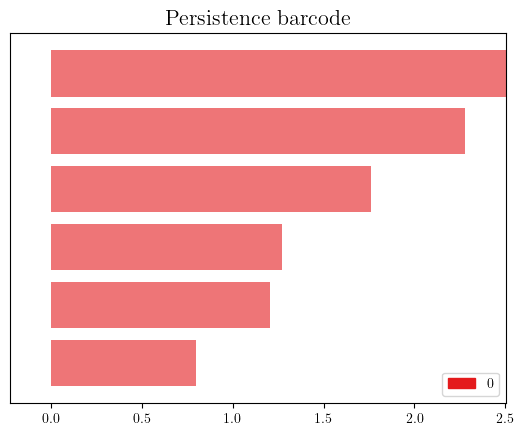

Bottleneck distance: 0.22168337405723437
Wasserstein distance: = 0.66


In [17]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "at the top of their game")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "at the top of their game")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

Tokens of the sub-collection: ['pulling', 'rabbits', 'out', 'of', 'hats']
Distance matrix: (5, 5)
Distance matrix: [[0.         2.5226179  2.69692891 5.23987603 3.54729565]
 [2.5226179  0.         2.63985536 4.99114747 3.24145987]
 [2.69692891 2.63985536 0.         4.58341324 2.58946229]
 [5.23987603 4.99114747 4.58341324 0.         2.61137718]
 [3.54729565 3.24145987 2.58946229 2.61137718 0.        ]]


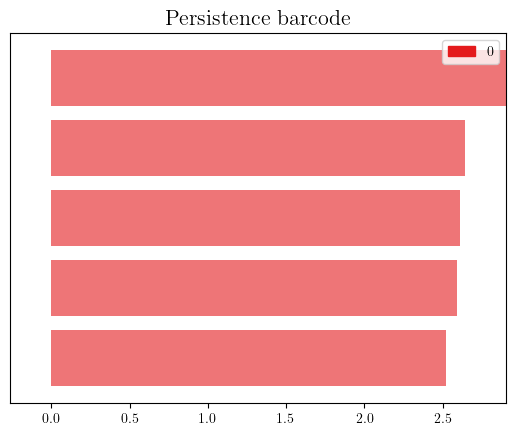

Tokens of the sub-collection: ['pulling', 'rabbits', 'out', 'of', 'hats']
Distance matrix: (5, 5)
Distance matrix: [[0.         2.48286698 2.71137965 5.37450335 3.89628949]
 [2.48286698 0.         2.07623439 4.8862622  3.26784373]
 [2.71137965 2.07623439 0.         4.15680717 2.39984215]
 [5.37450335 4.8862622  4.15680717 0.         2.07390507]
 [3.89628949 3.26784373 2.39984215 2.07390507 0.        ]]


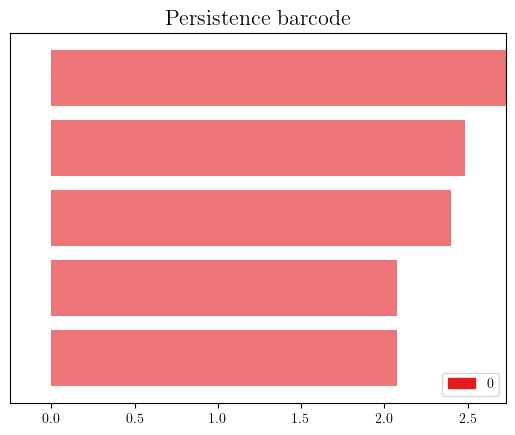

Bottleneck distance: 0.5132279018707417
Wasserstein distance: = 1.33


In [18]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "pulling rabbits out of hats")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "pulling rabbits out of hats")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

---

## Low Overlap in Collocations and Multiword Expressions

In [19]:
text_5 = ["In the heart of the bustling city, a small magic shop drew the attention of passersby with its unusual window displays. The owner, a retired magician, was famous for his ability to keep pulling rabbits out of hats, no matter how many times he had seemingly emptied them. His shop was a treasure trove of mysterious artifacts, enchanted props, and old books filled with forgotten spells. He would often perform impromptu magic shows for customers, effortlessly switching between levitating objects, disappearing acts, and card tricks. The climax of these shows would always see him pulling a rabbit out of an ostensibly empty hat, leaving the audience in stunned silence before they would invariably break into applause."]

text_6 = ["The tech start-up, nestled in a nondescript office park, was not much to look at from the outside. Yet, the team of engineers and designers inside were on the cutting edge of innovation, consistently pulling rabbits out of hats with their groundbreaking designs. Their latest product was a revolutionary smartwatch that boasted capabilities far beyond any existing model. During product launches, the CEO, a charismatic figure, would take to the stage and unveil the new device. As he demonstrated its features, like holographic displays and energy-efficient bio-sensors, the audience would watch in awe. As the presentation came to a close, showcasing a surprising feature - a mini drone that could detach from the watch and fly around for short distances - the crowd would invariably break into applause."]

In [20]:
context_5 = [compute_output(t, layer, head) for t in text_5]

context_6 = [compute_output(t, layer, head) for t in text_6]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relations

Tokens of the sub-collection: ['pulling', 'rabbits', 'out', 'of', 'hats']
Distance matrix: (5, 5)
Distance matrix: [[0.         1.2470203  1.69908898 4.24467822 3.88417237]
 [1.2470203  0.         1.29652952 4.1581243  3.80095003]
 [1.69908898 1.29652952 0.         3.64577622 3.27264446]
 [4.24467822 4.1581243  3.64577622 0.         0.51151233]
 [3.88417237 3.80095003 3.27264446 0.51151233 0.        ]]


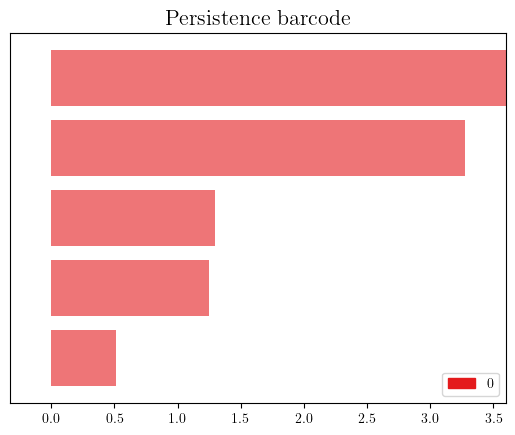

Tokens of the sub-collection: ['pulling', 'rabbits', 'out', 'of', 'hats']
Distance matrix: (5, 5)
Distance matrix: [[0.         1.09183944 1.46973704 4.44731053 3.82175228]
 [1.09183944 0.         1.6339098  4.41686389 3.81329989]
 [1.46973704 1.6339098  0.         3.90344201 3.24357288]
 [4.44731053 4.41686389 3.90344201 0.         0.70791077]
 [3.82175228 3.81329989 3.24357288 0.70791077 0.        ]]


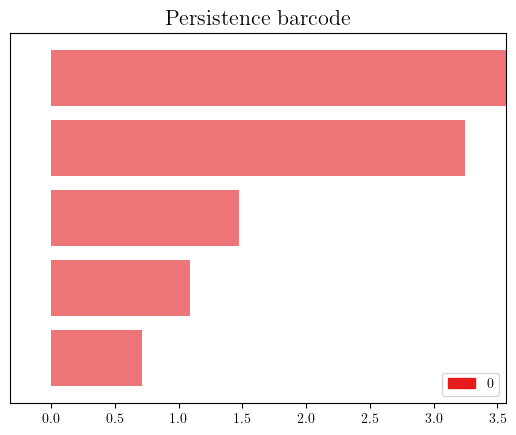

Bottleneck distance: 0.1963984438618056
Wasserstein distance: = 0.55


In [21]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_5[0], text_5[0], "pulling rabbits out of hats")
persistent_homology_2 = compute_phrase_distances_and_homology(context_6[0], text_6[0], "pulling rabbits out of hats")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

Tokens of the sub-collection: ['break', 'into', 'applause']
Distance matrix: (3, 3)
Distance matrix: [[0.         0.8391669  1.65103511]
 [0.8391669  0.         1.17429032]
 [1.65103511 1.17429032 0.        ]]


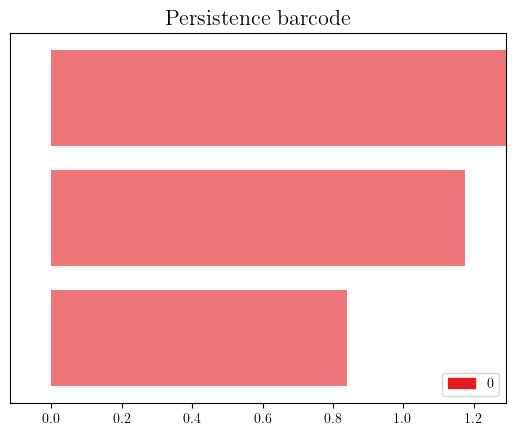

Tokens of the sub-collection: ['break', 'into', 'applause']
Distance matrix: (3, 3)
Distance matrix: [[0.         0.64279375 1.42671401]
 [0.64279375 0.         1.22481904]
 [1.42671401 1.22481904 0.        ]]


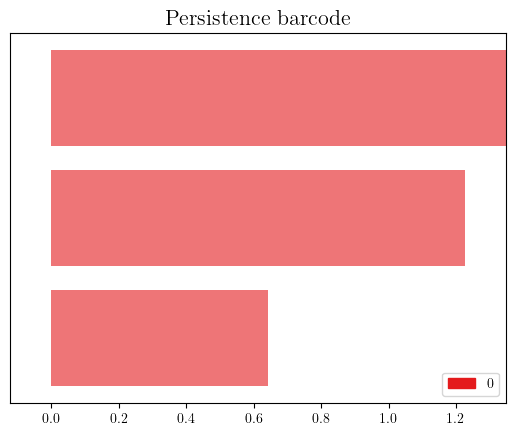

Bottleneck distance: 0.19637314911616377
Wasserstein distance: = 0.25


In [22]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_5[0], text_5[0], "break into applause")
persistent_homology_2 = compute_phrase_distances_and_homology(context_6[0], text_6[0], "break into applause")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")